# 4/23: Plate 1

Gates tentatively determined relative to shapes and percentages outlined in Farhat et al. Figure S3. Here, magnitudes have been transformed by log10, but do not appear consistent with S3.

In [1]:
import os
import string
import numpy as np
import pandas as pd
from FlowCytometryTools import ThresholdGate, PolyGate
from matplotlib import pyplot as plt
from matplotlib import cm
from flow import importF

/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
path_ = os.path.abspath('')

In [3]:
sample1A, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 1/Plate 1 - Panel 1 IL2R/", "A")
sample2B, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 1/Plate 1 - Panel 2 IL2R/", "B")
sample3C, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 1/Plate 1 - Panel 3 IL2R/", "C")

In [4]:
def combineWells(samples, channels_):
    """Accepts sample array returned from importF, and array of channels, returns transformed combined well data"""
    combinedSamples = samples[0]
    for sample in samples[1:]:
        combinedSamples.data = combinedSamples.data.append(sample.data)
    t_combinedSamples = combinedSamples.transform('tlog', channels=channels_)
    return t_combinedSamples

In [5]:
sample_all = combineWells(sample1A, ["FSC-H", "SSC-H", "SSC-A", 'VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H'])
sample_all.data = sample_all.data.append(combineWells(sample2B, ["FSC-H", "SSC-H", "SSC-A", 'VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H']).data)
sample_all.data = sample_all.data.append(combineWells(sample3C, ["FSC-H", "SSC-H", "SSC-A", 'VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H']).data)

/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/transforms.py:80: RuntimeWarning: invalid value encountered in log10
  return where(x <= th, log10(th) * 1. * r / d, log10(x) * 1. * r / d)


## A) Preliminary Gating - Singlet Lymphocytes

Text(0.5, 1.0, 'All Events')

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


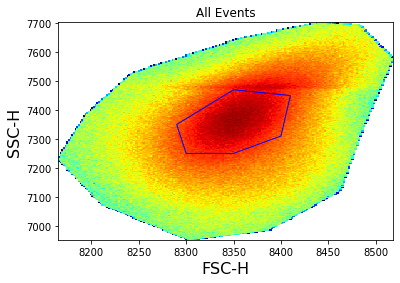

In [6]:
lymphocyte_gate = PolyGate([(8300, 7250), (8350, 7250), (8400, 7310), (8410, 7450), (8350, 7470), (8290, 7350)], ('FSC-H', 'SSC-H'), region='in', name='nk')
_ = sample_all.plot(["FSC-H", "SSC-H"], gates=lymphocyte_gate, cmap=cm.jet)
plt.title("All Events")

Above shape appears consistent with Farhat et al. S3(A)

Percent Lymphocytes gated as Singlets:  92.58151625990982 %


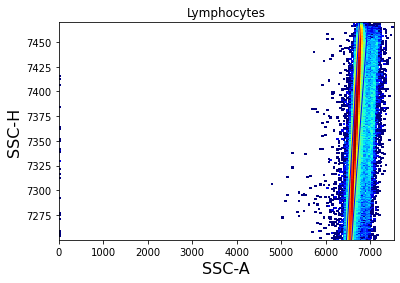

In [7]:
sample_all = sample_all.gate(lymphocyte_gate)
singlet_gate = PolyGate([(6400, 7200), (6800, 7500), (7000, 7500), (6500, 7200)], ('SSC-A', 'SSC-H'), region='in', name='nk')
_ = sample_all.plot(["SSC-A","SSC-H"], gates=singlet_gate, cmap=cm.jet)
plt.title("Lymphocytes")
print("Percent Lymphocytes gated as Singlets: ", sample_all.gate(singlet_gate).counts/sample_all.counts*100., "%")
sample_all = sample_all.gate(singlet_gate)

Above shape appears consistent with Farhat et al. S3(A), and the percentage gated is within range (83-94%).

## C) T helper and T regulatory cells

Percent gated as CD3+CD4+:  19.277866206385585 %


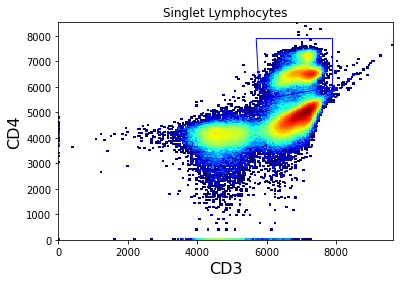

In [8]:
cd3cd4_gate = PolyGate([(5.5e03, 5.8e03), (6.0e03, 7.9e03), (7.9e03, 7.9e03), (7.9e03, 5.7e03)], ('VL6-H', 'VL4-H'), region='in', name='cd3cd4')
_ = sample_all.plot(['VL4-H','VL6-H'], gates=cd3cd4_gate, cmap=cm.jet) #CD3, CD4
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD4")
print("Percent gated as CD3+CD4+: ", sample_all.gate(cd3cd4_gate).counts/sample_all.counts*100., "%")

The above plot was inconsistent with S3(C). The gating was determined by selecting the uppermost region of density as in the paper, but the percentage gated is also inconsistent.

Percent gated as T helper:  79.22838952180845 %
Percent gated as Treg:  6.044704416593637 %


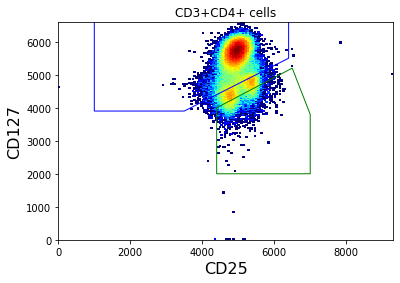

In [9]:
samplecd3cd4 = sample_all.gate(cd3cd4_gate)
thelp_gate = PolyGate([(3.9e03, 1e03), (3.9e03, 3.5e03), (5.5e03, 6.4e03), (6.8e03, 6.4e03), (6.8e03, 1e03)], ('BL1-H', 'VL1-H'), region='in', name='thelp')
treg_gate = PolyGate([(4.0e03, 4.4e03), (5.2e03, 6.5e03), (3.8e03, 7e03), (2.0e3, 7e03), (2.0e3, 4.4e03)], ('BL1-H', 'VL1-H'), region='in', name='treg')
_ = samplecd3cd4.plot(['VL1-H','BL1-H'], gates=[thelp_gate,treg_gate], cmap=cm.jet) #CD3, CD4
plt.title("CD3+CD4+ cells")
plt.xlabel("CD25")
plt.ylabel("CD127")
print("Percent gated as T helper: ", samplecd3cd4.gate(thelp_gate).counts/samplecd3cd4.counts*100., "%")
print("Percent gated as Treg: ", samplecd3cd4.gate(treg_gate).counts/samplecd3cd4.counts*100., "%")

The gates were determined mostly by percentage gated, as the shape here appears more dense than in S3(C).

In [10]:
samplethelp = samplecd3cd4.gate(thelp_gate)
sampletreg = samplecd3cd4.gate(treg_gate)

Percent gated as Memory T helper:  19.264905781070922 %
Percent gated as Naive T helper:  75.60569311548815 %


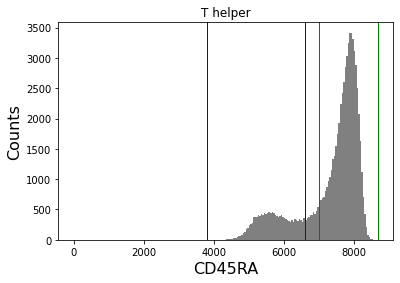

In [17]:
memthelpgate = ThresholdGate(6600.0, ['BL3-H'], region='below') & ThresholdGate(3800.0, ['BL3-H'], region='above')
naivethelpgate = ThresholdGate(7000.0, ['BL3-H'], region='above') & ThresholdGate(8700.0, ['BL3-H'], region='below')
_ = samplethelp.plot(['BL3-H'], gates=[memthelpgate,naivethelpgate])
plt.xlabel("CD45RA")
plt.title("T helper")
print("Percent gated as Memory T helper: ", samplethelp.gate(memthelpgate).counts/samplethelp.counts*100., "%")
print("Percent gated as Naive T helper: ", samplethelp.gate(naivethelpgate).counts/samplethelp.counts*100., "%")

The percentages gated here are inconsistent with S3(C) when following the thresholds based on shape.

Percent gated as Memory Treg:  60.19213973799127 %
Percent gated as Naive Treg:  25.20524017467249 %


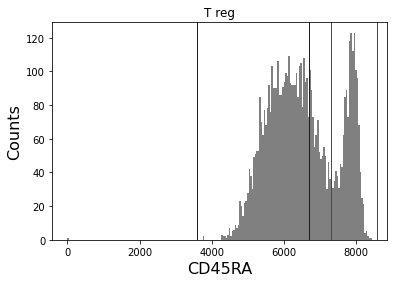

In [12]:
memtreggate = ThresholdGate(6700.0, ['BL3-H'], region='below') & ThresholdGate(3600.0, ['BL3-H'], region='above')
naivetreggate = ThresholdGate(7300.0, ['BL3-H'], region='above') & ThresholdGate(8600.0, ['BL3-H'], region='below')
_ = sampletreg.plot(['BL3-H'], gates=[memtreggate,naivetreggate])
plt.xlabel("CD45RA")
plt.title("T reg")
print("Percent gated as Memory Treg: ", sampletreg.gate(memtreggate).counts/sampletreg.counts*100., "%")
print("Percent gated as Naive Treg: ", sampletreg.gate(naivetreggate).counts/sampletreg.counts*100., "%")

The shape is more irregular than S3(C), so these gates were determined mostly by percentage gated.

## D) NK Cells

Percent gated as NK:  7.7764027242343685 %
Percent gated as NKT:  1.730328479484789 %


Text(0, 0.5, 'CD56')

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


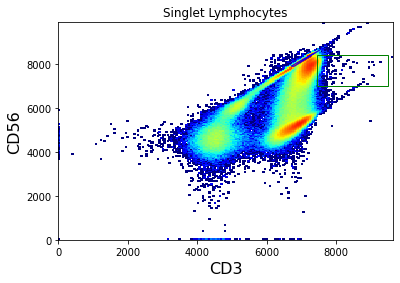

In [13]:
nk_gate = PolyGate([(6700, 7900), (6800, 7900), (7600, 8700)], ('VL4-H', 'BL3-H'), region='in', name='nk')
nkt_gate = PolyGate([(7450, 8400), (7450, 7000), (9500, 7000), (9500, 8400)], ('VL4-H', 'BL3-H'), region='in', name='nkt')
_ = sample_all.plot(['VL4-H', 'BL3-H'], gates=[nk_gate,nkt_gate], cmap=cm.jet) #CD56 vs. CD3
samplenk = sample_all.gate(nk_gate)
samplenkt = sample_all.gate(nkt_gate)
print("Percent gated as NK: ", samplenk.counts/sample_all.counts*100., "%")
print("Percent gated as NKT: ", samplenkt.counts/sample_all.counts*100., "%")
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD56")

This shape seemed to deviate the most from S3(D). The gates attempt to emulate the relative location/density of those in the paper, but were primarily determined by percentage gated.

Due to the differing shape, we tried normalizing with forward scatter to account for size with no significant change.

Text(0, 0.5, 'CD56')

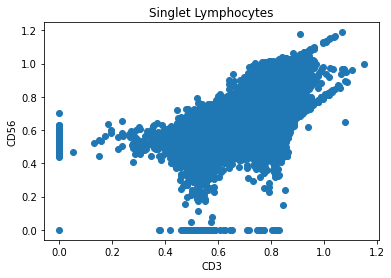

In [14]:
y = sample_all['BL3-H'] / sample_all['FSC-H']
x = sample_all['VL4-H'] / sample_all['FSC-H']
plt.rcParams['agg.path.chunksize'] = 10000
plt.scatter(x, y) # doesn't fix shape
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD56")

## E) CD8+ T cells

Percent gated as CD3+CD8+:  19.16754529874169 %


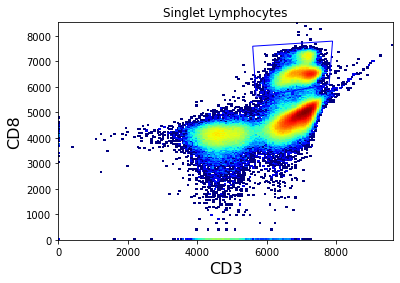

In [15]:
cd8_gate = PolyGate([(5700, 5600), (5600, 7600), (7900, 7800), (7800, 6100)], ('VL4-H', 'VL6-H'), region='in', name='cd8')
_ = sample_all.plot(['VL4-H', 'VL6-H'], gates=cd8_gate, cmap=cm.jet) #CD8 vs. CD3
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD8")
print("Percent gated as CD3+CD8+: ", sample_all.gate(cd8_gate).counts/sample_all.counts*100., "%")

The shape and percentage are relatively consistent with S3(E).

Percent gated as Cytotoxic Memory:  24.066306321613272 %
Percent gated as Cytotoxic Naive:  65.38351262092621 %


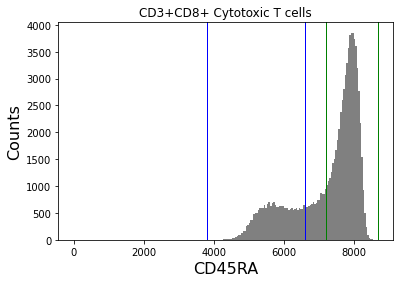

In [16]:
cd3cd8sample = sample_all.gate(cd8_gate)
memcd3cd8gate = ThresholdGate(6600.0, ['BL3-H'], region='below') & ThresholdGate(3800.0, ['BL3-H'], region='above')
naivecd3cd8gate = ThresholdGate(7200.0, ['BL3-H'], region='above') & ThresholdGate(8700.0, ['BL3-H'], region='below')
_ = cd3cd8sample.plot(['BL3-H'], gates=[memcd3cd8gate,naivecd3cd8gate])
plt.xlabel("CD45RA")
plt.title("CD3+CD8+ Cytotoxic T cells")
print("Percent gated as Cytotoxic Memory: ", cd3cd8sample.gate(memcd3cd8gate).counts/cd3cd8sample.counts*100., "%")
print("Percent gated as Cytotoxic Naive: ", cd3cd8sample.gate(naivecd3cd8gate).counts/cd3cd8sample.counts*100., "%")

The shape is similar to S3(E), but the percentages are off.